In [35]:
import glob, json, os
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# 配置工作目录
os.chdir("/root/autodl-tmp/proj/Week10/codes")
print("当前目录:", os.getcwd())

img_paths = glob.glob('../ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()
print(f"total imgs={len(img_paths)}")
img_paths = img_paths[:3000]
img_paths[:2]

当前目录: /root/autodl-tmp/proj/Week10/codes
total imgs=30000


['../ai_challenger_caption_validation_20170910/caption_validation_images_20170910/0003a0755539c426ecfc7ed79bc74aeea6be740b.jpg',
 '../ai_challenger_caption_validation_20170910/caption_validation_images_20170910/000420107b8abee7c2f08bb21e4444a9d00c9323.jpg']

In [36]:
validation_annotations = json.load(
    open('../ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)
print(f"total annotations={len(validation_annotations)}")
validation_annotations[:2]

total annotations=30000


[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [37]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}

In [38]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

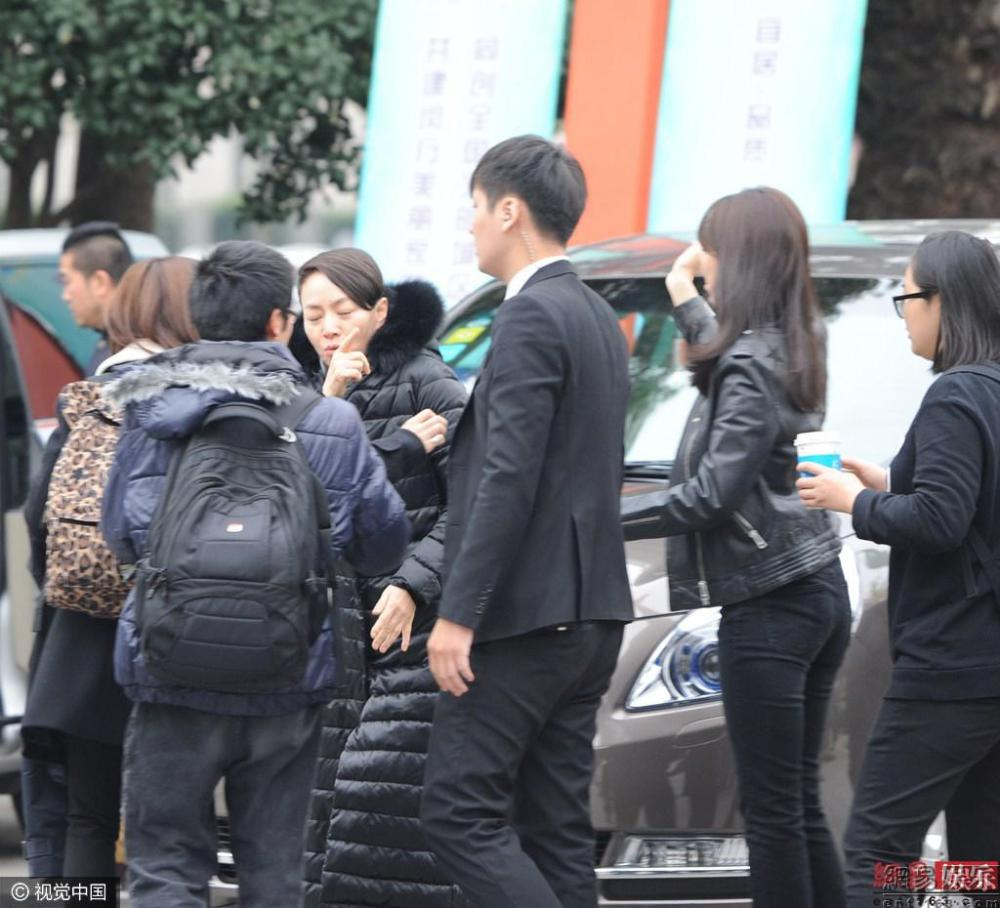

In [39]:
Image.open(img_paths[2])

In [40]:
img_captions[2]

'道路上一群人的旁边有一个右手比着手势的女人在说话'

# 加载CLIP模型

In [41]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

#官方OPENAI clip不支持中文
#https://www.modelscope.com/models/AI-ModelScope/chinese-clip-vit-base-patch16

model = ChineseCLIPModel.from_pretrained("../../../models/AI-ModelScope/chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained("../../../models/AI-ModelScope/chinese-clip-vit-base-patch16",use_fast=True) # 预处理

# 图像编码

In [42]:
img_image_feat = []

batch_size = 20
for idx in tqdm(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")  #图预处理，提取图的编码结果
    #inputs.pop("token_type_ids", None)    #对于图像，通常不需要删除token_type_ids
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)
        
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

  0%|          | 0/151 [00:00<?, ?it/s]

In [43]:
img_image_feat.shape # 3000张图片 512 维度

(3000, 512)

# 文本编码

In [48]:
from tqdm import tqdm

def get_chinese_clip_text_features(model, texts, processor, batch_size=20):
    """Chinese-CLIP 文本特征提取修复版本（带进度条）"""
    all_features = []
    
    # 计算总批次数量
    total_batches = (len(texts) + batch_size - 1) // batch_size
    print(f"总文本数: {len(texts)}, 批次大小: {batch_size}, 总批次: {total_batches}")
    
    # 使用 tqdm 进度条
    for idx in tqdm(range(0, len(texts), batch_size), desc="处理文本批次"):
        batch_texts = texts[idx:idx+batch_size]
        
        if not batch_texts:
            continue
            
        # 清理文本
        cleaned_texts = [str(text).strip() if text else " " for text in batch_texts]
        
        try:
            # 处理文本
            inputs = processor(
                text=cleaned_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=77
            )
            
            with torch.no_grad():
                # 获取文本模型输出
                text_outputs = model.text_model(**inputs)
                
                # !!Chinese-CLIP 使用 [CLS] token 作为池化输出!!
                last_hidden_state = text_outputs.last_hidden_state
                pooled_output = last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
                
                # 应用投影层
                text_features = model.text_projection(pooled_output)
                all_features.append(text_features.cpu().numpy())
                
        except Exception as e:
            print(f"\n批次 {idx//batch_size} 处理失败: {e}")
            # 添加零向量作为占位符
            batch_size_actual = len(cleaned_texts)
            feature_dim = model.text_projection.out_features if hasattr(model.text_projection, 'out_features') else 512
            all_features.append(np.zeros((batch_size_actual, feature_dim)))
            continue
    
    return np.vstack(all_features) if all_features else np.array([])

# 使用修复的方法
print("开始提取文本特征...")
img_texts_feat = get_chinese_clip_text_features(model, img_captions, processor, batch_size=20)

if img_texts_feat.size > 0:
    img_texts_feat = normalize(img_texts_feat)
    print(f"\n成功提取 {img_texts_feat.shape[0]} 个文本特征，形状: {img_texts_feat.shape}")
else:
    print("\n没有提取到文本特征")

开始提取文本特征...
总文本数: 3000, 批次大小: 20, 总批次: 150


处理文本批次: 100%|██████████| 150/150 [00:19<00:00,  7.55it/s]


成功提取 3000 个文本特征，形状: (3000, 512)


In [49]:
img_texts_feat.shape

(3000, 512)

# 尝试1：相似度计算

In [50]:
query_idx = 250

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][1:4]

输入文本:  宽敞的大厅里一个穿着长裙的女人抱着东西站在四个手里拿着东西的人旁边


([], [])

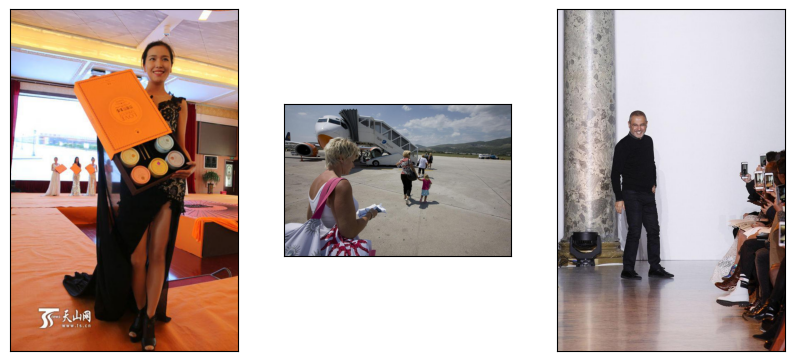

In [51]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [52]:
query_idx = 250

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['一个右手拿着扇子的男人搂着一个弯着腰的女人站在干净的舞台上', '一个穿着裙子的女人站在背景板前的红地毯上', '一位女士抱着一个小孩子站在舞台上']


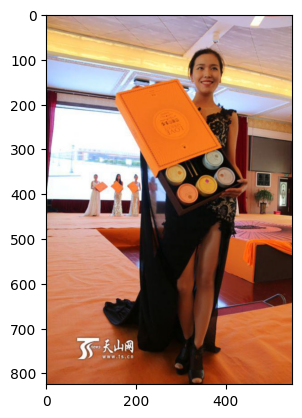

In [53]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [55]:
import jieba

In [56]:
jieba.lcut('今天天气很好，心情也很好。')

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.672 seconds.
Prefix dict has been built successfully.


['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [57]:
jieba.lcut(img_captions[0])

['一个',
 '穿着',
 '裙子',
 '的',
 '女孩',
 '双手',
 '拿',
 '着',
 '东西',
 '站',
 '在',
 '宽阔',
 '的',
 '草地',
 '上']

In [58]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [59]:
img_captions2words[:10]

['一个', '穿着', '裙子', '的', '女孩', '双手', '拿', '着', '东西', '站']

In [60]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [61]:
img_captions2words[:10]

['购物车', '一对', '温馨', '羊圈', '盛饭', '男子', '长筒靴', '山脚下', '风尘', '游戏机']

In [64]:
img_texts_feat = []
batch_size = 20

def get_single_text_feature(model, processor, text):
    """处理单个文本的特征提取"""
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True, max_length=77)
    
    with torch.no_grad():
        text_outputs = model.text_model(**inputs)
        last_hidden_state = text_outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]
        text_features = model.text_projection(pooled_output)
        
    return text_features.cpu().numpy()

for idx in tqdm(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    text_features=get_single_text_feature(model, processor, text)
    img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

100%|██████████| 82/82 [00:02<00:00, 38.84it/s]


# 尝试2：标签相似度计算

In [65]:
query_idx = 120

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

文本识别结果:  ['穿鞋', '球拍', '船上', '哈哈大笑', '阳光', '公交车']


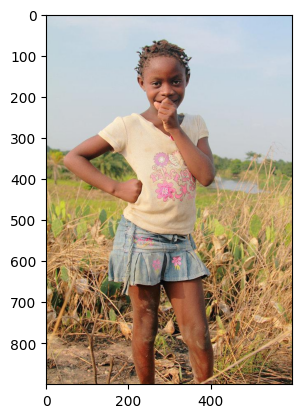

In [66]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])